# Development: Sky coverage priority

**Problem:** We do not observe the full sky; (a) we avoid the Galactic plane, (b) each instrument has a declination limit. Therefore, each observatory has corresponding fields in a limited sky region. Close to the edges of this region a field has fewer neighbors than deep within the region. This affects the method of *prioritization by sky coverage*, where a field that has many finished neighboring fields gets prioritized over a field with fewer finished neighboring fields.

In this notebook I test different approaches to defining the *sky coverage priority*.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

## Simple approach: Coverage relative to the local number of neighbors

The coverage is calculated as such, where $n_\mathrm{tot}$ is the total number of neighboring fields and $n_\mathrm{done}$ is the number of finished fields:

$\frac{n_\mathrm{done}}{n_\mathrm{tot}}$

This way the priority is `1` when the field is the last one required to finish up the neighborhood, and `0` when no neighboring field has been finished.

In [12]:
def coverage_local(n_done, n_tot):
    return n_done / n_tot

We are demonstrating this approach for two fields, one with 19 neighbors (closer to the edge of the sky region covered by the survey), the other with 39 neighbors (within the sky region).

In [13]:
n_done_few = np.arange(20)
n_done_many = np.arange(40)

fraction_few = coverage_local(n_done_few, n_done_few.max())
fraction_many = coverage_local(n_done_many, n_done_many.max())

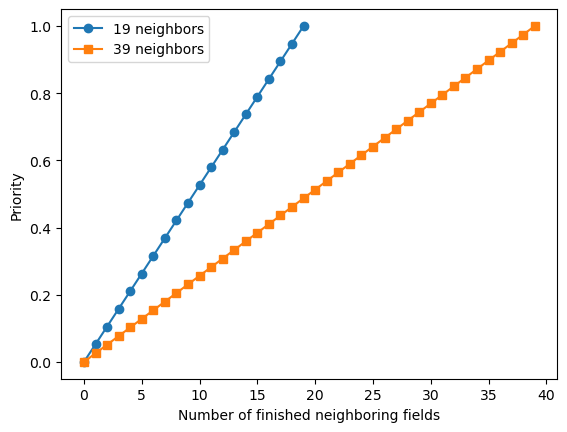

In [14]:
plt.plot(n_done_few, fraction_few, marker='o', label='19 neighbors')
plt.plot(n_done_many, fraction_many, marker='s', label='39 neighbors')
plt.legend(loc='best')
plt.xlabel('Number of finished neighboring fields')
plt.ylabel('Priority');

**Discussion:**

* A field with fewer neighbors and some number of them finished will always get higher priority than a field with more neighbors and the same number of fields finished.
* Consequentially, fields near the edge get prioratized.
* This is in principle reasonable:
    * A field with 19 neighbors and 15 therefore finished just needs 5 more fields (including this one) in the neighborhood to finish up the neighborhood.
    * A field with 39 neighbors and 15 finished still needs 25 more fields to finish up the neighborhood.
    * The field with 19 neighbors and 15 finished gets a priority of 0.8. The field with 39 neighbors needs 31 fields finished to get the same priority.
* However, we may not want to prioritize fields near edges from the start. As the figure above demonstrates a field with just 19 neighbors, none thereof finished, will get a higher priority than a field with 39 neighbors and none thereof finished.

## Alternative approach: Coverage relative to the maximum number of neighbors

Here, we use the maximum number of neighbors among all fields, $\max(n_\mathrm{tot})$, as denominator, i.e. the number of neighbors that a typical field within the covered sky region has. This way we ignore that fields close to the edge have fewer neighbors.

$\frac{n_\mathrm{done}}{\max(n_\mathrm{tot})}$

In [16]:
def coverage_max(n_done, n_tot_max):
    return n_done / n_tot_max

In [17]:
n_done_few = np.arange(20)
n_done_many = np.arange(40)

fraction_few = coverage_max(n_done_few, n_done_many.max())
fraction_many = coverage_max(n_done_many, n_done_many.max())

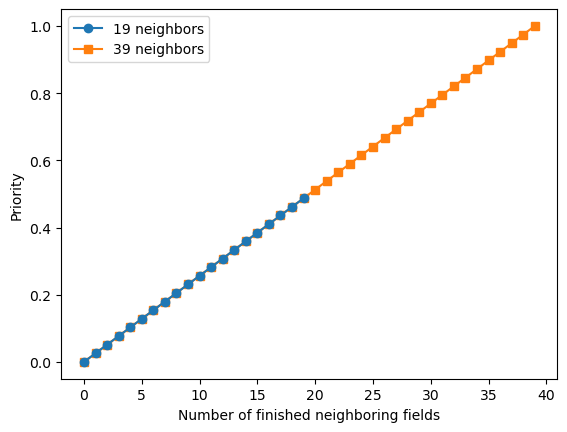

In [18]:
plt.plot(n_done_few, fraction_few, marker='o', label='19 neighbors', zorder=1)
plt.plot(n_done_many, fraction_many, marker='s', label='39 neighbors', zorder=0)
plt.legend(loc='best')
plt.xlabel('Number of finished neighboring fields')
plt.ylabel('Priority');

**Discussion:**

* Any field with zero neighbors finished or one field finished, etc. will get the same priority, regardless of the number of local neighbors.
* Therefore, fields with fewer neightbors (near the sky region edge) do not get prioritized from the start.
* However, fields near the edges now get low prioritization even when they are close to finishing the neighborhood:
    * A field with 20 neighbors and 19 finished gets priority 0.5. This field would complete the neighborhood.
    * The same priority is assigned to a field with 39 neighbors and 19 thereor finished. This field would only reach 50% of neighborhood completion.
* This way fields near the edges will overall get lower priority, even when they will complete the local region. There will be many more fields within the region than near the edge. Therefore, it is to be expected that the edges will take long to finish.

## A combined approach: adaptive weighting between both approaches

**Idea:** When we start the survey, i.e. when no fields are observed yet, we do not want to prioritize fields near the edges over fields within the region. Here, the second approach is more useful. When the survey progresses and fields near the edge will complete the local region whereas fields further away from the edge may still need more observation to finish the local region, regions that will quickly finish the local region should be prioritized. Here, the first approach is more useful.

We use both approaches and combine them with weights that depend on the completion fraction of the local region:

$\frac{n_\mathrm{done}}{n_\mathrm{tot}} \times w_1 + \frac{n_\mathrm{done}}{\max(n_\mathrm{tot})} \times w_2$,

where

$w_1 = \frac{n_\mathrm{done}}{n_\mathrm{tot}}$

and 

$w_2 = 1 - \frac{n_\mathrm{done}}{n_\mathrm{tot}}$.

In [19]:
def coverage_combined(n_done, n_tot, n_tot_max):
    coverage1 = coverage_local(n_done, n_tot)
    coverage2 = coverage_max(n_done, n_tot_max)
    weight1 = n_done / n_tot
    weight2 = 1. - weight1
    coverage = coverage1 * weight1 + coverage2 * weight2
    
    return coverage

In [20]:
n_done_few = np.arange(20)
n_done_many = np.arange(40)

fraction_few = coverage_combined(n_done_few, n_done_few.max(), n_done_many.max())
fraction_many = coverage_combined(n_done_many, n_done_many.max(), n_done_many.max())

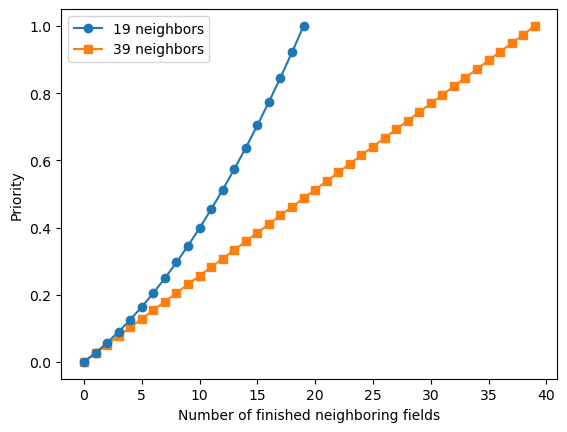

In [21]:
plt.plot(n_done_few, fraction_few, marker='o', label='19 neighbors', zorder=1)
plt.plot(n_done_many, fraction_many, marker='s', label='39 neighbors', zorder=0)
plt.legend(loc='best')
plt.xlabel('Number of finished neighboring fields')
plt.ylabel('Priority');

**Discussion:**

* This approach combines the best of both approaches above:
    * When few neighboring fields are finished, fields with fewer neighbors (i.e. near the edge) are not strongly prioritized over fields away from the edge.
    * When only few fields are needed to finish a local region, priority is given to those fields are will quickly finish the local region. I.e. a field near the edge will be prioritized if if is contributing more strongly to finishing up its neighboring region (with fewer fields) than a field away from the edge which may need more neighboring fields to be finished to have the same impact.
* This is the approach I am going to implement in the survey planner.